<a href="https://colab.research.google.com/github/ZXY0827/CS6220_Final-Project/blob/main/cs6220_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# 2. Load dataset
# url = 'https://www.kaggle.com/datasets/fedesoriano/california-housing-prices-data-extra-features'
df = pd.read_csv('/content/California_Houses.csv')

In [3]:
# 3. Exploratory Data Analysis (EDA)
# Display basic information about the dataset:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Median_House_Value        20640 non-null  float64
 1   Median_Income             20640 non-null  float64
 2   Median_Age                20640 non-null  int64  
 3   Tot_Rooms                 20640 non-null  int64  
 4   Tot_Bedrooms              20640 non-null  int64  
 5   Population                20640 non-null  int64  
 6   Households                20640 non-null  int64  
 7   Latitude                  20640 non-null  float64
 8   Longitude                 20640 non-null  float64
 9   Distance_to_coast         20640 non-null  float64
 10  Distance_to_LA            20640 non-null  float64
 11  Distance_to_SanDiego      20640 non-null  float64
 12  Distance_to_SanJose       20640 non-null  float64
 13  Distance_to_SanFrancisco  20640 non-null  float64
dtypes: flo

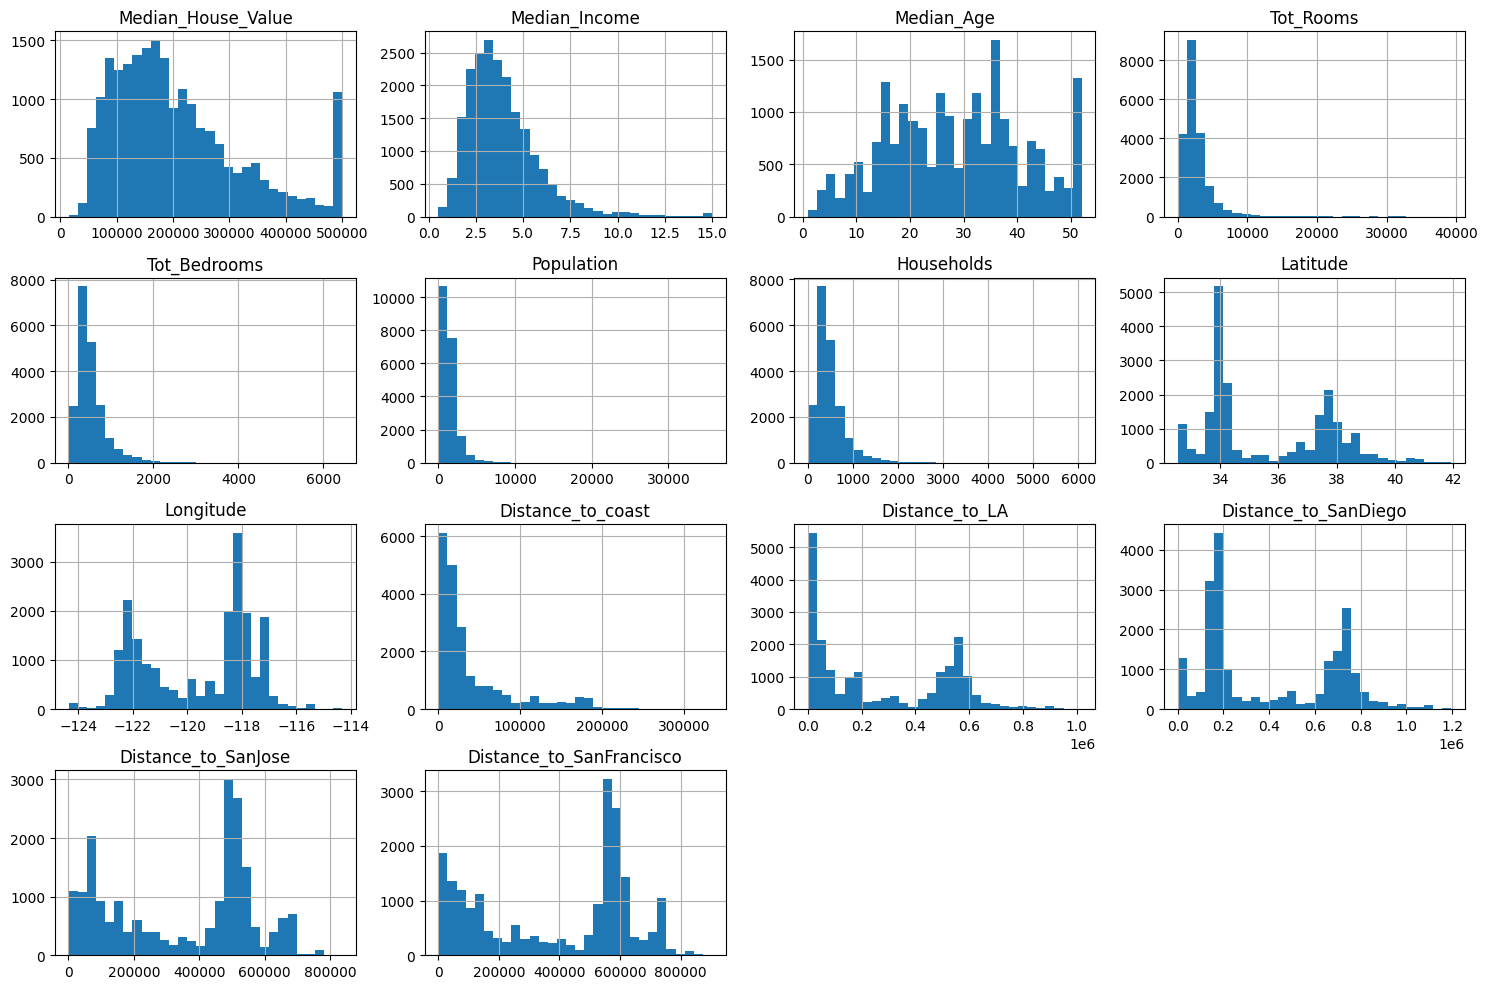

In [4]:
# 4. Plot histograms for all numeric features in the dataset.
# This visualization helps us understand the distribution of each feature, detect skewness, and identify potential outliers.
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


In [5]:
#5
print(df.columns)

Index(['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms',
       'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude',
       'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego',
       'Distance_to_SanJose', 'Distance_to_SanFrancisco'],
      dtype='object')


In [6]:
# 6. Data Cleaning: Remove rows with capped house values ($500,000)
# Before visualization, we remove capped house values ($500,000) to better observe the true relationship
# between income and housing prices without distortion caused by the ceiling effect.

df = df[df['Median_House_Value'] < 500000].copy()

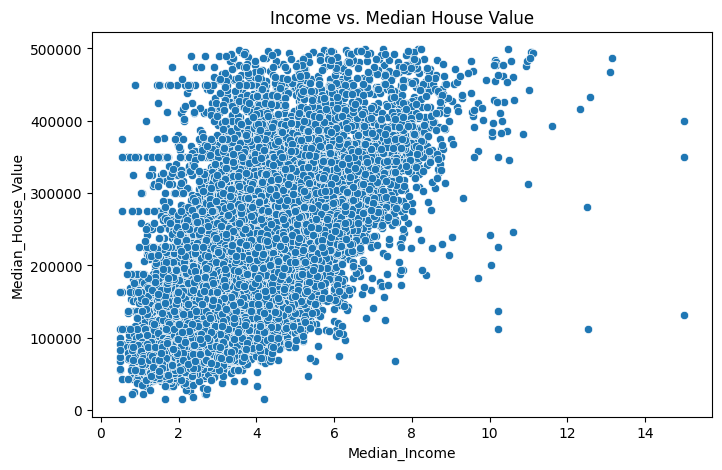

In [7]:
# 7. Scatter plot to visualize the relationship between median income and house value.
# Each point represents a neighborhood or block group
# Helps identify correlation between income and housing prices
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Median_Income', y='Median_House_Value', data=df)
plt.title('Income vs. Median House Value')
plt.show()

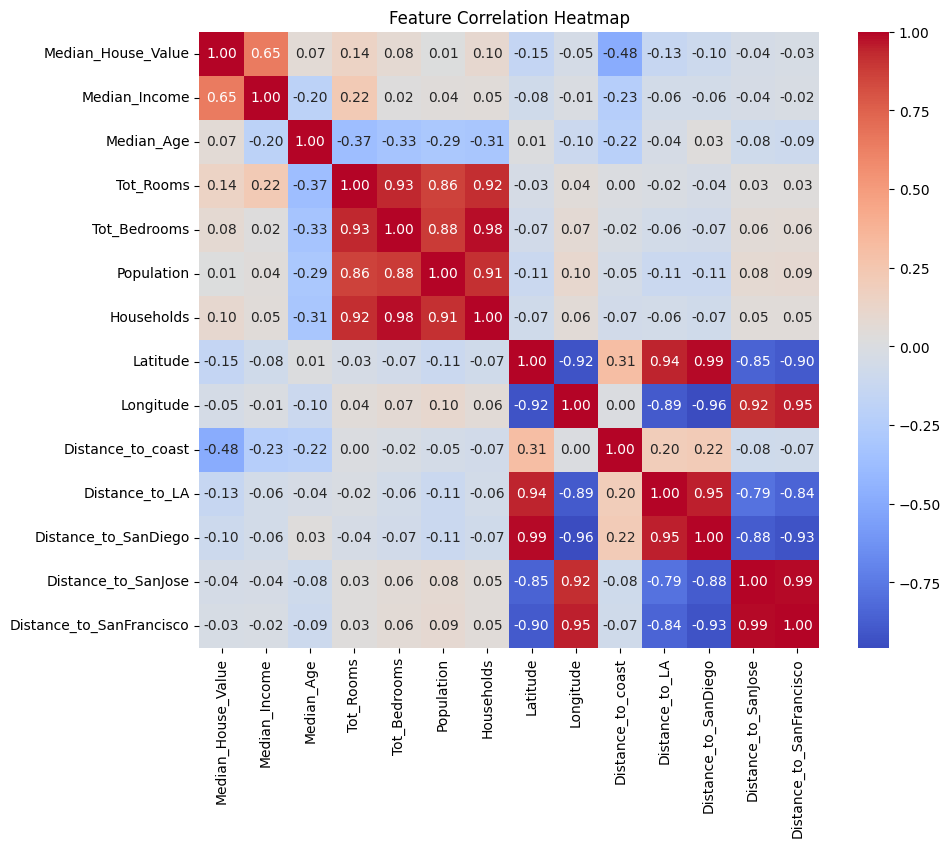

In [8]:
# 8. Plot a correlation heatmap to visualize the linear relationships between numerical features.
# 'cmap="coolwarm"' sets the color theme from blue (negative correlation) to red (positive correlation).
# This helps identify which features are strongly correlated with the target variable
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [9]:
# 9. Preprocessing
# Separate the features (X) and the target variable (y).
# 'Median_House_Value' is the variable we want to predict, so we exclude it from the input features.
X = df.drop('Median_House_Value', axis=1)
y = df['Median_House_Value']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

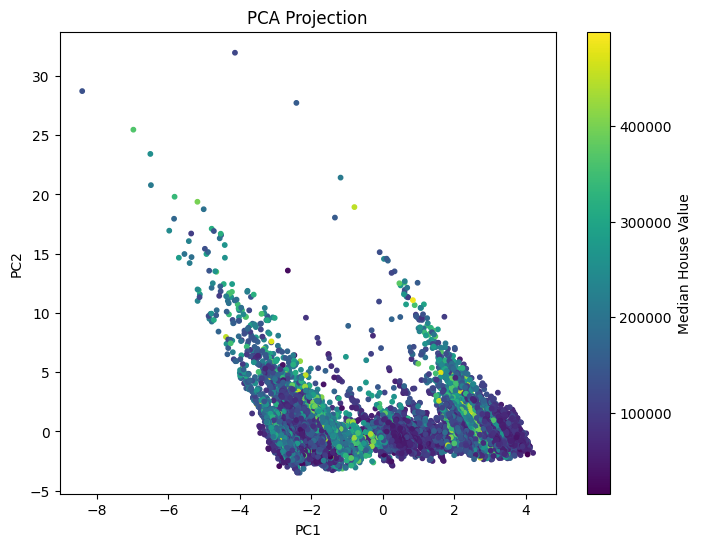

In [10]:
# 10. PCA for visualization (not for modeling). Apply Principal Component Analysis (PCA) to reduce feature dimensions to 2.
# This is used for visualization only, not for training the predictive model.
# Although PCA is not used for modeling, this 2D projection helps visualize clusters or variance patterns in house pricing.
# PCA finds the directions (principal components) that capture the most variance in the data.
# Here, we use the standardized features (X_scaled) to ensure fair comparison between variables.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# This helps visualize how housing prices vary across the dataset in compressed 2D space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=10)
plt.title('PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Median House Value')
plt.show()

In [11]:
# 11. Display explained variance ratio
print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)

Explained variance by PC1 and PC2: [0.43593883 0.29543566]


In [12]:
# 12. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# 13. Train all models and store results
# Define a dictionary of models to evaluate:
# - Linear Regression: simple baseline model
# - Decision Tree: non-linear model with limited depth
# - Random Forest: ensemble of decision trees for better generalization
# - Gradient Boosting: sequential ensemble that corrects previous errors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Initialize result containers
trained_models = {}
model_names = []
r2_scores = []
rmses = []
residuals_dict = {}
y_preds_dict = {}


# Train each model and evaluate using R² and RMSE
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate residuals: the difference between actual and predicted values
    residuals = y_test - y_pred

    # Evaluate the model using R² score and RMSE
    # R² Score (Coefficient of Determination): measures how well the model explains variance in the target variable.
    # Values closer to 1 indicate better performance.
    # RMSE (Root Mean Squared Error): measures the average difference between predicted and actual values.
    # Lower RMSE indicates better accuracy.
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    model_names.append(name)
    r2_scores.append(r2)
    rmses.append(rmse)
    trained_models[name] = model
    residuals_dict[name] = residuals
    y_preds_dict[name] = y_pred


results_df = pd.DataFrame({
    'Model': model_names,
    'R²': r2_scores,
    'RMSE': rmses
})
print(" Model Performance Comparison:")
print(results_df.sort_values(by='R²', ascending=False))

 Model Performance Comparison:
               Model        R²          RMSE
2      Random Forest  0.804651  43276.663845
3  Gradient Boosting  0.754432  48521.444344
0  Linear Regression  0.614295  60810.020553
1      Decision Tree  0.599800  61942.138707


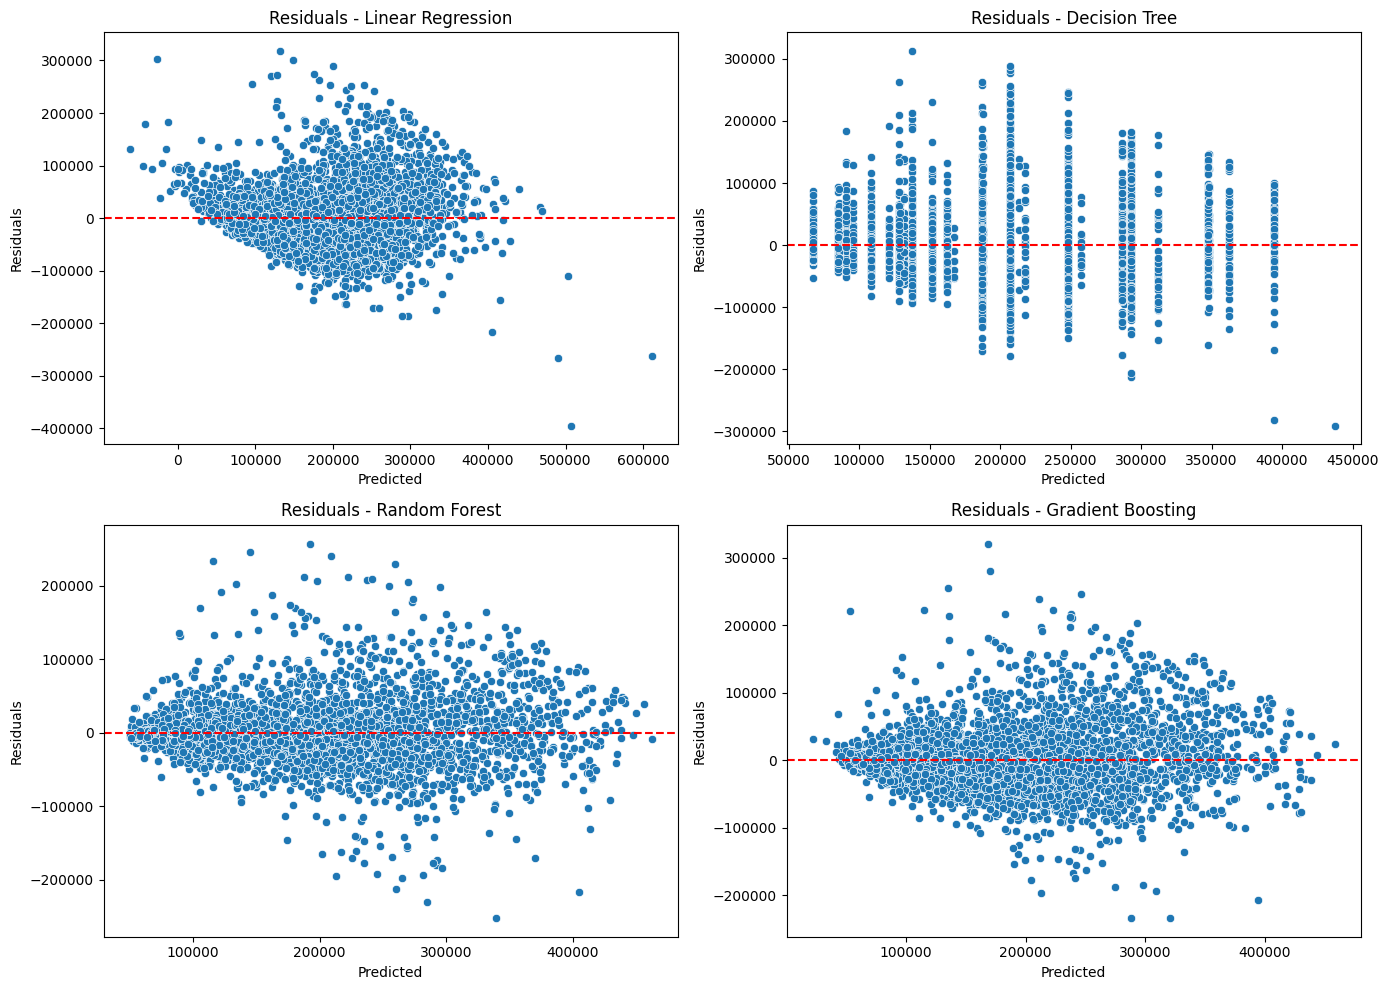

In [14]:
# 14. Residual Plot （Plot residuals vs. predicted values）
# This plot helps diagnose model performance and assumptions.
# Ideally, residuals should be randomly scattered around zero with no clear pattern.
# Patterns (e.g., curves, funnel shapes) may indicate non-linearity, heteroscedasticity, or model bias.
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, name in enumerate(model_names):
    sns.scatterplot(x=y_preds_dict[name], y=residuals_dict[name], ax=axs[idx])
    axs[idx].axhline(0, color='red', linestyle='--')
    axs[idx].set_title(f"Residuals - {name}")
    axs[idx].set_xlabel("Predicted")
    axs[idx].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

## Residual Analysis

To evaluate model performance beyond numeric metrics like R² and RMSE, we examine the residual plots of each model.

- **Residuals** represent the difference between actual and predicted house values.
- Ideally, residuals should be randomly scattered around 0 with no clear patterns.
- Non-random patterns (e.g., funnel shapes or curves) indicate model bias, heteroscedasticity, or inability to capture complex relationships.


- **Linear Regression**: Residuals show a clear funnel shape, indicating heteroscedasticity. The model struggles with high-priced homes.
- **Decision Tree**: Residuals appear "striped" and uneven due to limited splits (max_depth=5), revealing underfitting and poor generalization.
- **Random Forest**: Residuals are evenly scattered, suggesting stable performance and good handling of non-linear patterns.
- **Gradient Boosting**: Residuals are also well-distributed, though slightly more concentrated. It performs better than linear models and captures complex structures.

Overall, ensemble models (Random Forest & Gradient Boosting) produce more reliable and stable predictions compared to single-tree or linear models.


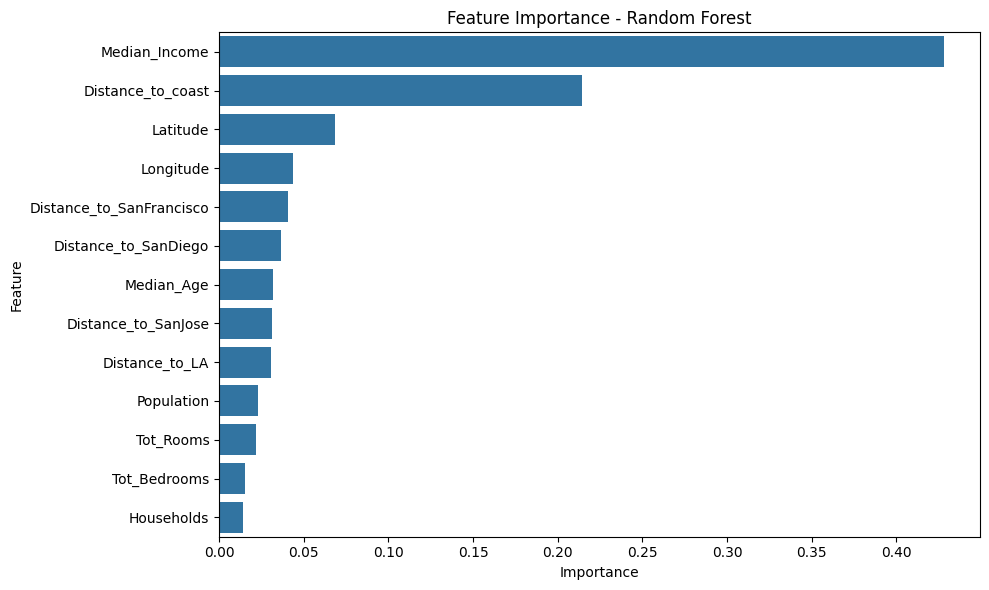

In [15]:
# 15. Feature Importance from Random Forest
# Step 1: Extract feature importance values from the trained Random Forest model
# Each value indicates how much that feature contributes to the prediction
rf_model = trained_models["Random Forest"]
importances = rf_model.feature_importances_

# Step 2: Get the original feature names from the dataset
feat_names = X.columns

# Step 3: Create a DataFrame to associate feature names with their importance values
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})

# Step 4: Sort the features by importance in descending order
feat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Step 5: Visualize feature importances using a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Feature Importance Interpretation:
# The bar chart illustrates the importance of each feature in the Random Forest model:
# Median_Incomeis by far the most influential feature, suggesting a strong positive correlation between income levels and housing prices in California.
# Distance_to_coast and Latitude also contribute significantly, indicating that proximity to the ocean and geographical location play important roles in housing value.
# Other variables like Distance to major cities and Median_Age have moderate influence.
# Structural features such as Total Rooms, Population, and Households were found to have relatively low predictive power.
# This analysis helps us understand which factors drive housing prices and enhances model transparency.


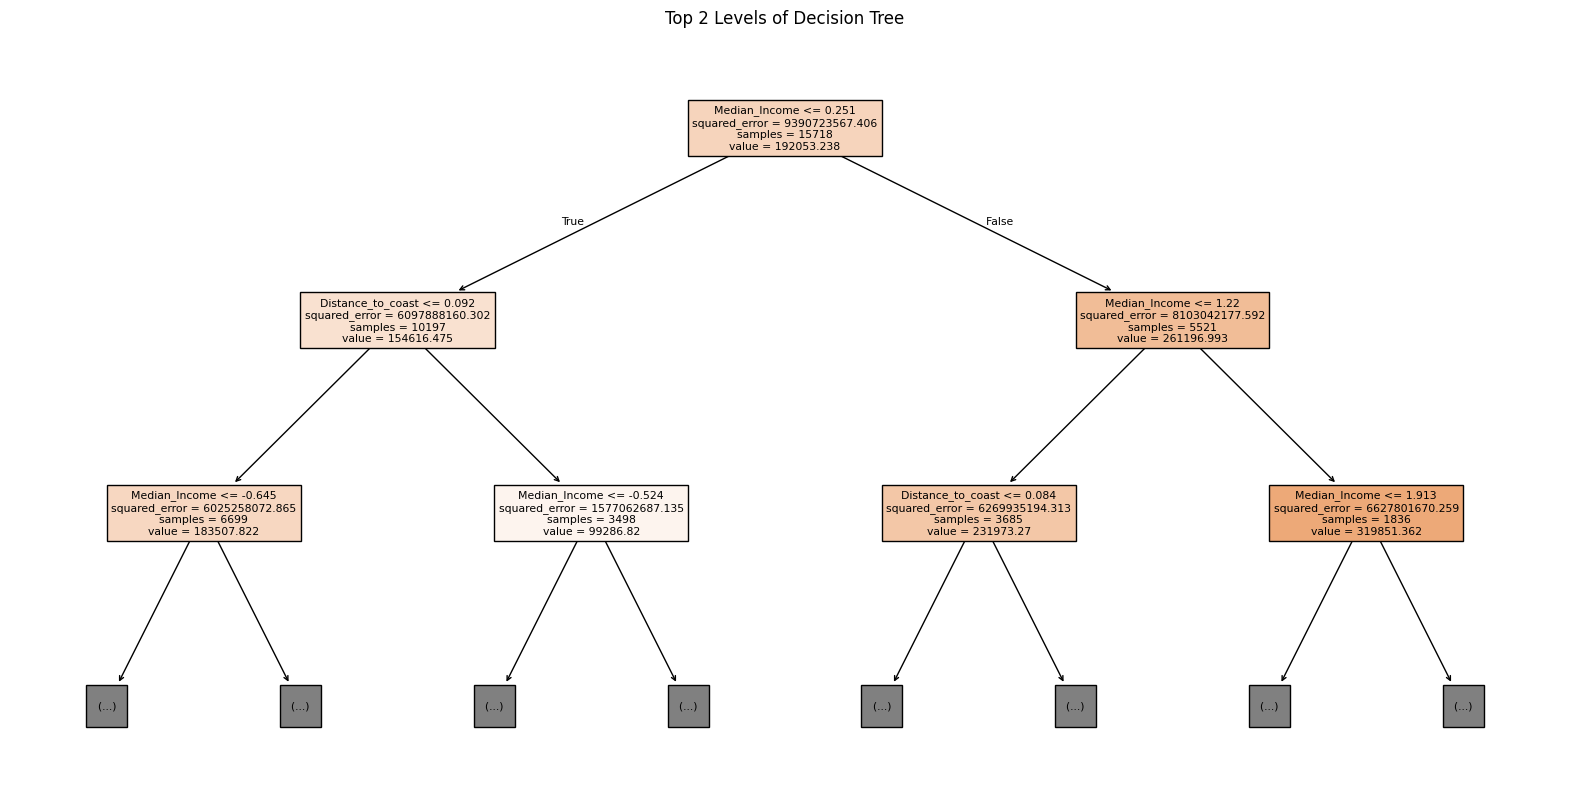

In [16]:
# 16. Visualize the top 2 levels of the trained Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
dt_model = trained_models["Decision Tree"]

# Plot the top 2 levels of the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, filled=True, max_depth=2)
plt.title("Top 2 Levels of Decision Tree")
plt.show()

### Decision Tree (Top 2 Levels)

This visualization shows the top 2 levels of the trained Decision Tree model.

- The first split is based on Median_Income, highlighting its dominant influence.
- The second-level splits involve Distance_to_coast, suggesting geographic proximity also plays a key role.
- These early splits reveal how the model prioritizes socioeconomic and location-based features when predicting house prices.

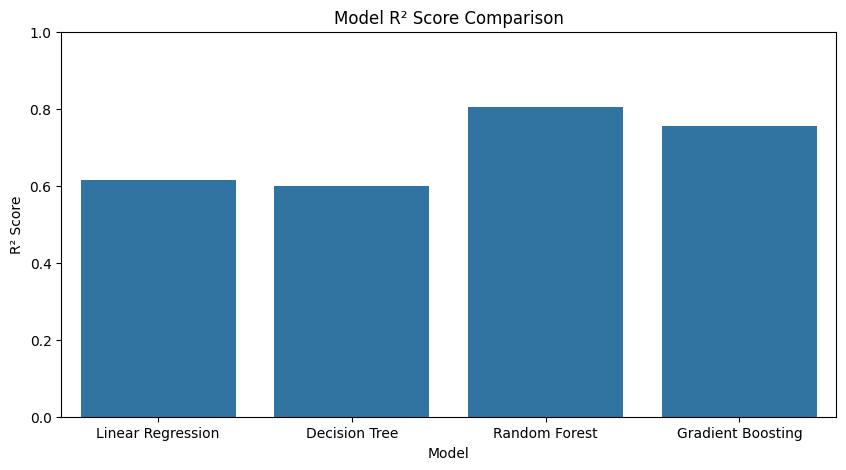

In [17]:
# 17. Visualize R² scores of all models for easy comparison
# Higher R² means better model fit to the data
# This bar chart highlights which model captures the most variance
plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=r2_scores)
plt.ylim(0, 1)
plt.title("Model R² Score Comparison")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.show()

## Summary & Insights

### Model Performance
- **Random Forest** achieved the best overall performance with the highest R² score (**0.8047**) and the lowest RMSE (**≈ 43,276.66**).
- **Gradient Boosting** also performed well (R² = **0.7544**), outperforming simpler models.
- **Linear Regression** and **Decision Tree** underperformed, suggesting that linear models and shallow trees are insufficient for capturing the complexity of the housing data.

### Residual Analysis
- **Linear Regression** exhibited clear heteroscedasticity (funnel-shaped residuals), indicating that it fails to model variance across the full price range.
- **Decision Tree** showed underfitting and inconsistent predictions.
- **Random Forest** and **Gradient Boosting** had residuals more evenly distributed around zero, highlighting their ability to handle non-linear relationships and variance better.

### Feature Importance
- **Median Income** was by far the most influential predictor of housing prices.
- Geographic features like **Distance to Coast** and **Latitude** also played significant roles.
- Structural features (e.g., total rooms, population) contributed less to predictive power.

### Conclusion
Tree-based ensemble models like **Random Forest** and **Gradient Boosting** significantly outperform linear and shallow models in housing price prediction, primarily due to their ability to capture complex, non-linear interactions in the data.

That said, while **tree-based models offer superior accuracy**, **linear models** still provide value through their simplicity and interpretability — which can be important in business applications where model transparency matters.
